#Event Detection (ED)

Event detection (ED) is a task in Natural Language Processing (NLP) that aims to identify event triggers and categorize events mentioned in the text. Event detection is essential because it may be used to automatically annotate more linguistic resources and improve the precision of other NLP tasks that depend   on event detection, including question answering or machine translation. In this paper, the author presents different deep learning approaches with a remarkable F-1 score to find out event detection in the pre-tokenized sentence, these event detection labels are based on the BIO format. The total number of labels according to BIO format is 11 (B-Sentiment, B-Scenario, B-Change, B-Possession, B-Action, I-Sentiment, I-S:cenario, I-Change, I-Possession, I-Action, and O).


> **This the flow of the task. Where the inputs 
are lists of tokens that make up the sentence. And our task is to find out event detection with their labels.**


 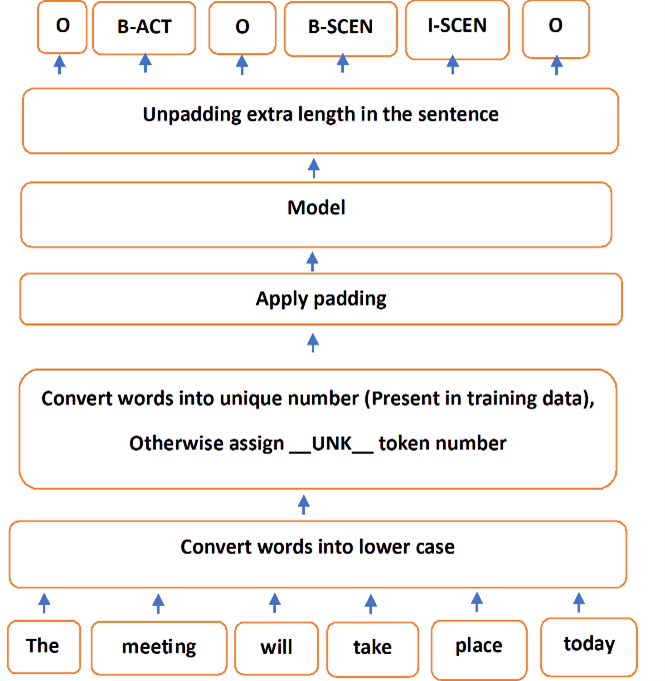





# Import Libraries

In [ ]:
!pip install seqeval

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=54b162f165f657f080dcad1f162e581f79b342fb30a9ee6cf26eb9105e4dfe12
  Stored in directory: /root/.cache/pip/wheels/e2/a5/92/2c80d1928733611c2747a9820e1324a6835524d9411510c142
Successfully built seqeval


In [ ]:
!nvidia-smi

Wed Apr 26 09:52:21 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import pandas as pd

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset,TensorDataset,DataLoader

from tqdm import tqdm

from time import sleep

import sklearn
from sklearn.metrics import confusion_matrix

import seaborn as sns


import gensim
import gensim.downloader

import seqeval
from seqeval.metrics import classification_report, f1_score
from seqeval.metrics.sequence_labeling import accuracy_score
from seqeval.scheme import IOB2

from google.colab import drive

torch.manual_seed(0)

In [ ]:
print('Matplotlib Version : ',matplotlib._get_version())
print('Pandas Version : ',pd.__version__)
print("Numpy Version : ",np.__version__)
print("Torch Version : ",torch.__version__)
print("Sklearn Version : ",sklearn.__version__)
print("Seaborn Version : ",sns.__version__)
print("Gensim Version : ",gensim.__version__)

Matplotlib Version :  3.7.1
Pandas Version :  1.5.3
Numpy Version :  1.22.4
Torch Version :  2.0.0+cu118
Sklearn Version :  1.2.2
Seaborn Version :  0.12.2
Gensim Version :  4.3.1


# Setup


## Cuda Check
---






In [ ]:
torch.cuda.is_available()


True

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Google Drive Access (For Model Save)
---
For this HW1, I am using google colab for GPU, So that's reason. I want to connect to drive to save my every batch data to my drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


# Data Preparation

In [ ]:
train_path = '/content/train.jsonl'
test_path = '/content/test.jsonl'
val_path = '/content/dev.jsonl'

In [ ]:
df_train = pd.read_json(train_path,lines=True)
df_test = pd.read_json(test_path,lines=True)
df_val = pd.read_json(val_path,lines=True)

In [ ]:
df_train = df_train.dropna()
df_test = df_test.dropna()
df_val = df_val.dropna()

In [ ]:
df_train.head()

,idx,tokens,labels
0,0,"[Hard, Rock, Hell, III, :, The, Vikings, Ball, .]","[O, O, O, O, O, O, O, O, O]"
1,1,"[Casualties, and, damage, were, severe, on, bo...","[B-SCENARIO, O, B-CHANGE, O, O, O, O, O, O, O,..."
2,2,"[This, incident, led, to, violence, in, Al, An...","[O, B-SENTIMENT, B-CHANGE, I-CHANGE, B-ACTION,..."
3,3,"[As, of, 2016, ,, aspects, of, the, crisis, in...","[O, O, O, O, O, O, O, B-SCENARIO, O, O, O, O, ..."
4,4,"[the, depression, tracked, northwestward, ,, i...","[O, O, B-ACTION, O, O, B-CHANGE, O, O, B-SCENA..."


In [ ]:
df_test.head()

,idx,tokens,labels
0,0,"[The, show, includes, trade, stands, ,, intera...","[O, O, B-CHANGE, O, O, O, O, O, O, O, O, O, O,..."
1,1,"[Gradually, weakening, after, veering, back, w...","[O, B-CHANGE, O, B-ACTION, O, O, O, O, O, O, O..."
2,2,"[additionally, ,, the, storm, was, the, first,...","[O, O, O, O, O, O, O, O, B-ACTION, O, O, O, O,..."
3,3,"[With, increasing, Iranian, involvement, in, S...","[O, B-CHANGE, O, O, O, O, O, O, O, O, O, O, B-..."
4,4,"[TVXQ, 's, international, concert, tours, ofte...","[O, O, O, O, O, O, B-ACTION, O, O, O, O, O, O]"


In [ ]:
df_val.head()

,idx,tokens,labels
0,0,"[However, ,, as, the, day, progressed, ,, Morr...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O]"
1,1,"[The, attacks, were, carried, out, in, a, narr...","[O, B-ACTION, O, B-ACTION, I-ACTION, O, O, O, ..."
2,2,"[Just, a, Pretty, Face, ?]","[O, O, O, O, O]"
3,3,"[The, failure, to, take, Madras, was, a, huge,...","[O, O, O, B-CHANGE, O, O, O, O, O, O, O, O, O,..."
4,4,"[While, the, uprising, was, part, of, a, large...","[O, O, B-CHANGE, O, O, O, O, O, O, O, B-CHANGE..."


In [ ]:
def test_dataset(df):
  print("Dataset:")
  for sample, list_tokens, list_labels in zip(range(len(df[:5])),df.tokens.values[:5],df.labels.values[:5]):
    print(f'Sample : {sample+1}',end='')
    print(" ",end='')
    print('Data {} '.format([str(token)+':'+str(label) for token,label in zip(list_tokens,list_labels)]))

In [ ]:
test_dataset(df_train)

Dataset:
Sample : 1 Data ['Hard:O', 'Rock:O', 'Hell:O', 'III:O', '::O', 'The:O', 'Vikings:O', 'Ball:O', '.:O'] 
Sample : 2 Data ['Casualties:B-SCENARIO', 'and:O', 'damage:B-CHANGE', 'were:O', 'severe:O', 'on:O', 'both:O', 'sides:O', ',:O', 'and:O', 'the:O', 'defiance:O', 'of:O', 'the:O', 'French:O', 'ship:O', 'was:O', 'celebrated:B-ACTION', 'in:O', 'both:O', 'countries:O', 'as:O', 'a:O', 'brave:O', 'defence:O', 'against:O', 'overwhelming:O', 'odds:O', '.:O'] 
Sample : 3 Data ['This:O', 'incident:B-SENTIMENT', 'led:B-CHANGE', 'to:I-CHANGE', 'violence:B-ACTION', 'in:O', 'Al:O', 'Anbar:O', 'Governorate:O', 'between:O', 'the:O', 'Iraqi:O', 'Army:O', 'and:O', 'a:O', 'loose:O', 'alliance:O', 'of:O', 'tribal:O', 'militias:O', 'and:O', 'other:O', 'groups:O', 'fighting:B-ACTION', 'alongside:O', 'the:O', 'Islamic:O', 'State:O', 'in:O', 'Iraq:O', 'and:O', 'the:O', 'Levant:O', '(:O', 'ISIL:O', '):O', '.:O'] 
Sample : 4 Data ['As:O', 'of:O', '2016:O', ',:O', 'aspects:O', 'of:O', 'the:O', 'crisis:B-

In [ ]:
def labels_visualization(df,list_labels):
  labels_value = []
  for labels in df.labels.values:
    for label in labels:
      labels_value.append(label)

  

  val = [labels_value.count(i) for i in list_labels] # we skip 'O'

  fig = plt.figure(figsize = (15, 5))
 
  
  barlist = plt.bar(list_labels, val, color ='maroon',
          width = 0.4)
  
  
  plt.xlabel("Labels")
  plt.ylabel("Frequency")
  plt.title("Labels with different number of Frequency")
  plt.show()


With 'O', Most of the labels are annoted with the label 'O'. Other labels are not clearly visible

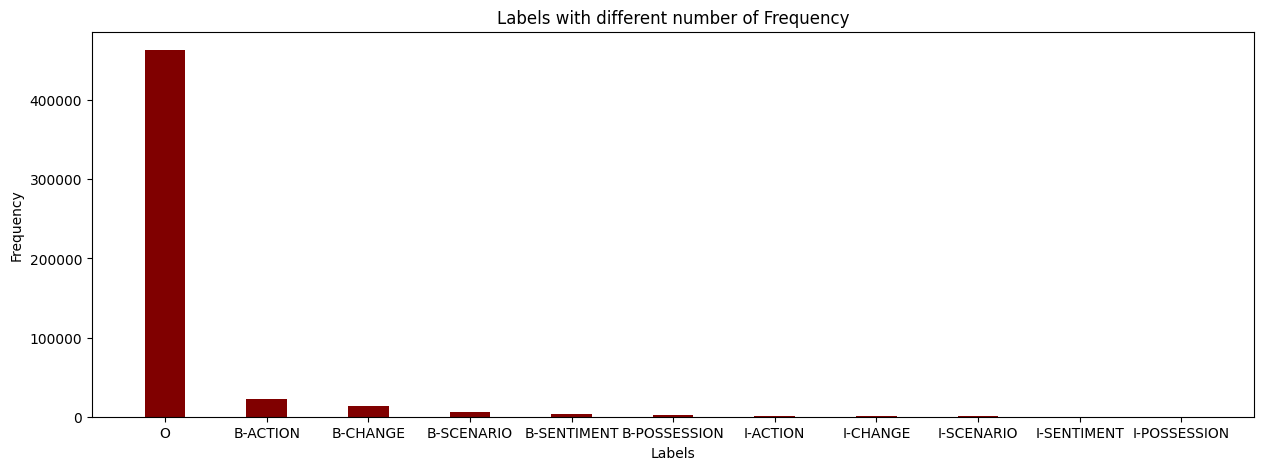

In [ ]:
list_labels = ['O','B-ACTION', 'B-CHANGE', 'B-SCENARIO', 'B-SENTIMENT', 'B-POSSESSION', 'I-ACTION', 'I-CHANGE', 'I-SCENARIO', 'I-SENTIMENT', 'I-POSSESSION',]
labels_visualization(df_train,list_labels)

Without 'O'. Now other labels are clearly visible

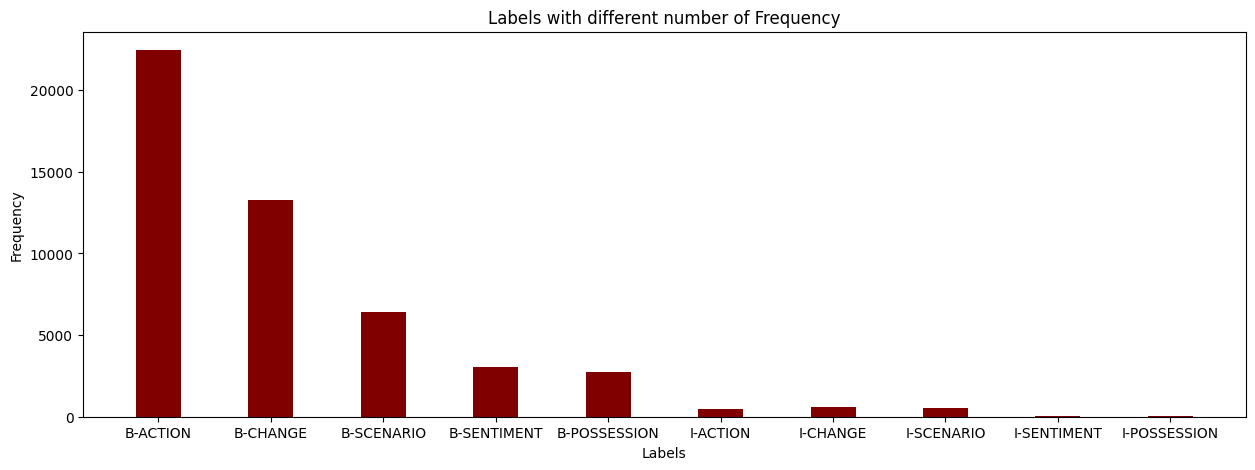

In [ ]:
list_labels = ['B-ACTION', 'B-CHANGE', 'B-SCENARIO', 'B-SENTIMENT', 'B-POSSESSION', 'I-ACTION', 'I-CHANGE', 'I-SCENARIO', 'I-SENTIMENT', 'I-POSSESSION',]
labels_visualization(df_train,list_labels)

In [ ]:
def tokens_lower(tokens_values):
  tokens = []
  for num in tqdm(range(len(tokens_values))):
    tokens.append(list(map(str.lower,tokens_values[num])))
  return tokens



def unique_tokens(tokens_list):
  unique_tokens = []
  for tokens in tokens_list:
    for token in tokens:
      unique_tokens.append(token)
  return set(unique_tokens)



def unique_labels(labels_list):
  unique_labels = []
  for labels in labels_list:
    for label in labels:
      unique_labels.append(labels)
  return set(unique_labels)


def save_vocab(vocab,file_name):
  with open(file_name, 'w') as fp:
      for item in list(vocab):
          fp.write("%s\n" % item)
      print(f'Vocabs Saved in {file_name} path')


def save_tags(tags,file_name):
  with open(file_name, 'w') as fp:
      for item in list(tags):
          fp.write("%s\n" % item)
      print(f'Tags Saved in {file_name} path')



def get_vocabs(file_path_vocab):
  vocabs = []

  
  with open(file_path_vocab, 'r') as fp:
      for line in fp:
          
          x = line[:-1]

          vocabs.append(x)
  return vocabs


def get_tags(file_path_tags):
   
  tags = []

  
  with open(file_path_tags, 'r') as fp:
      for line in fp:         
          x = line[:-1]        
          tags.append(x)
  return tags



## Convert Tokens in Lower Case
---
For better processing, we have to convert the 'tokens' values in the lower case  

In [ ]:
df_train_X = tokens_lower(df_train.tokens)
df_test_X = tokens_lower(df_test.tokens)
df_val_X = tokens_lower(df_val.tokens)

100%|██████████| 2000/2000 [00:00<00:00, 103066.81it/s]


In [ ]:
print("Before Lower Case",df_train.tokens[0])
print("After Lower Case",df_train_X[0])

Before Lower Case ['Hard', 'Rock', 'Hell', 'III', ':', 'The', 'Vikings', 'Ball', '.']
After Lower Case ['hard', 'rock', 'hell', 'iii', ':', 'the', 'vikings', 'ball', '.']


In [ ]:
sentences_words_train = df_train_X
sentences_words_test = df_test_X
sentences_words_val = df_val_X

In [ ]:
sentences_tags_train = df_train.labels.values
sentences_tags_test = df_test.labels.values
sentences_tags_val = df_val.labels.values

## Find out Unique Words and Tags
---
If we have previously unique vocab file and tags file skip this part. Otherwise coninue this part.

Now here we have to find out unique tags and unique words of **"TRAIN DATA"**


In [ ]:
vocabs = unique_tokens(sentences_words_train)
tags = unique_tokens(sentences_tags_train)

print("Total Number of Unique Words :",len(vocabs))
print([vocab for vocab in vocabs])
print("Total Number of Unique Tags :",len(tags))
print([tag for tag in tags])

Total Number of Unique Words : 33079
['installed', 'raciborz', '151,000', 'front', 'destabilisation', 'legacy', 'legislature', 'englishman', '65,000', '1762', 'kent', 'rebirth', 'miraumont', 'exacerbated', 'wurmser', 'centers', 'lightbody', 'unannounced', 'ufa', 'extrajudicial', '38.1', 'darío', 'vijay', 'novus', 'exclamation', 'detachment', 'dieumerci', 'kajakai', 'annihilated', 'war-related', '1,650', 'nim', '232', 'trim', 'albrecht', 'storm—in', 'assaf', 'better', 'stationmaster', 'observer', 'source', 'contemplated', 'angostura', 'calafate', 'headlined', 'lightning', 'mccachnie', 'afternoon', 'impression', 'wdr', 'noaa', 'otto', 'yolandita', 'amsterdam', 'netherlands', 'verifiable', 'triple-canopied', 'sample', 'gibraltar', 'however', 'brother-in-law', 'rat', 'flavell', 'estates-general', 'displaced', 'converged', 'terrific', 'rothenburg', 'endured', 'mo', 'azhar', 'saumarez', 'robbie', 'nigeria', 'resemblance', 'promoters', 'pontius', 'khê', 'back-and-forth', 'miguel', 'vox', 'ser

### Saved Unique Words and Tags
---
This vocabs and tags is unique, We have to use this in prediction time. So for that we need to save it.

In [ ]:
save_vocab(vocabs,'/content/drive/MyDrive/MODEL_CHECKPOINTS/vocabs.txt')
save_tags(tags,'/content/drive/MyDrive/MODEL_CHECKPOINTS/tags.txt')

Vocabs Saved in /content/drive/MyDrive/MODEL_CHECKPOINTS/vocabs.txt path
Tags Saved in /content/drive/MyDrive/MODEL_CHECKPOINTS/tags.txt path


## Load Words and Tags File
---
If we have unique vocab file and tags file previously the load it otherwise skip it this part.

In [ ]:
vocabs = get_vocabs('/content/drive/MyDrive/MODEL_CHECKPOINTS/vocabs.txt')
tags = get_tags('/content/drive/MyDrive/MODEL_CHECKPOINTS/tags.txt')

print("Total Number of Unique Words :",len(vocabs))
print([vocab for vocab in vocabs])
print("Total Number of Unique Tags :",len(tags))
print([tag for tag in tags])

Total Number of Unique Words : 33079
['installed', 'raciborz', '151,000', 'front', 'destabilisation', 'legacy', 'legislature', 'englishman', '65,000', '1762', 'kent', 'rebirth', 'miraumont', 'exacerbated', 'wurmser', 'centers', 'lightbody', 'unannounced', 'ufa', 'extrajudicial', '38.1', 'darío', 'vijay', 'novus', 'exclamation', 'detachment', 'dieumerci', 'kajakai', 'annihilated', 'war-related', '1,650', 'nim', '232', 'trim', 'albrecht', 'storm—in', 'assaf', 'better', 'stationmaster', 'observer', 'source', 'contemplated', 'angostura', 'calafate', 'headlined', 'lightning', 'mccachnie', 'afternoon', 'impression', 'wdr', 'noaa', 'otto', 'yolandita', 'amsterdam', 'netherlands', 'verifiable', 'triple-canopied', 'sample', 'gibraltar', 'however', 'brother-in-law', 'rat', 'flavell', 'estates-general', 'displaced', 'converged', 'terrific', 'rothenburg', 'endured', 'mo', 'azhar', 'saumarez', 'robbie', 'nigeria', 'resemblance', 'promoters', 'pontius', 'khê', 'back-and-forth', 'miguel', 'vox', 'ser

## Data Preprocessing
---

In [ ]:
def MAX_LENGTH(sentences_words_train,sentences_words_test,sentences_words_val):
  max_length = []
  for train in sentences_words_train:
    max_length.append(len(train))
  for test in sentences_words_test:
    max_length.append(len(test))
  for val in sentences_words_val:
    max_length.append(len(val))
  
  return max(max_length)


def tokenizer(unique_values,padding_token='__PADDING__',OOV_token='__UNK__',tagging=False):
  tokenized_val = {}
  if tagging == True:
    pass
  else:
    tokenized_val[OOV_token]=1
  tokenized_val[padding_token]=0
  value = len(tokenized_val)
  for i in unique_values:
    tokenized_val[i]=value
    value+=1

  return tokenized_val
  
def indexes(tokens):
  idx = {j:i for i,j in tokens.items()}
  return idx
  
def data2idx_vocabs(lst_vocabs, tokens):
  data2idx = []
  for vocabs in lst_vocabs:
    data = []
    for vocab in vocabs:
      if vocab in tokens:
        data.append(tokens[vocab])
      else:
        data.append(tokens['__UNK__'])
    data2idx.append(data)
  return data2idx

def data2idx_tags(lst_tags, tokens):
  data2idx = []
  for tags in lst_tags:
    data = []
    for tag in tags:
      data.append(tokens[tag])
    data2idx.append(data)
  return data2idx

### Max length of the sentences
---

Most of the sentences is not in the same length of words/vocabs for that reason we need to find out the maximum length of the training, testing and validation dataset

In [ ]:
MAX_LEN = MAX_LENGTH(sentences_words_train,sentences_words_test,sentences_words_val)
print("Maximum Length of sentence : ",MAX_LEN)

Maximum Length of sentence :  343


### Convert every vocabs or tags into the unique number
---
We find out the unique vocabs and tags, but in neural network we have to feed numbers not words. So for that we have to convert every vocabs and tags to the unique numbers. 

* Most of the time our data (sentences) is not same in length so for that we need to assign padding. For padding we use word `__PADDING__`.



* On the other most of the time we face Out of vocablary issue. To fix this issue, we have to assign `__UNK__` key for those words who are not in our training dataset.

In [ ]:
vocabs_tokenizer = tokenizer(vocabs)
print(vocabs_tokenizer)
index_vocab = indexes(vocabs_tokenizer)
print(index_vocab)
print('')
print('Unique tokens for Vocabs:', len(index_vocab))

{'__UNK__': 1, '__PADDING__': 0, 'installed': 2, 'raciborz': 3, '151,000': 4, 'front': 5, 'destabilisation': 6, 'legacy': 7, 'legislature': 8, 'englishman': 9, '65,000': 10, '1762': 11, 'kent': 12, 'rebirth': 13, 'miraumont': 14, 'exacerbated': 15, 'wurmser': 16, 'centers': 17, 'lightbody': 18, 'unannounced': 19, 'ufa': 20, 'extrajudicial': 21, '38.1': 22, 'darío': 23, 'vijay': 24, 'novus': 25, 'exclamation': 26, 'detachment': 27, 'dieumerci': 28, 'kajakai': 29, 'annihilated': 30, 'war-related': 31, '1,650': 32, 'nim': 33, '232': 34, 'trim': 35, 'albrecht': 36, 'storm—in': 37, 'assaf': 38, 'better': 39, 'stationmaster': 40, 'observer': 41, 'source': 42, 'contemplated': 43, 'angostura': 44, 'calafate': 45, 'headlined': 46, 'lightning': 47, 'mccachnie': 48, 'afternoon': 49, 'impression': 50, 'wdr': 51, 'noaa': 52, 'otto': 53, 'yolandita': 54, 'amsterdam': 55, 'netherlands': 56, 'verifiable': 57, 'triple-canopied': 58, 'sample': 59, 'gibraltar': 60, 'however': 61, 'brother-in-law': 62, 'r

In [ ]:
tags_tokenizer = tokenizer(tags,tagging=True)
print(tags_tokenizer)
index_tag = indexes(tags_tokenizer)
print(index_tag)
print('')
print('Unique tokens:', len(index_tag))

{'__PADDING__': 0, 'B-CHANGE': 1, 'I-POSSESSION': 2, 'B-SCENARIO': 3, 'O': 4, 'B-POSSESSION': 5, 'I-ACTION': 6, 'I-SCENARIO': 7, 'B-SENTIMENT': 8, 'B-ACTION': 9, 'I-SENTIMENT': 10, 'I-CHANGE': 11}
{0: '__PADDING__', 1: 'B-CHANGE', 2: 'I-POSSESSION', 3: 'B-SCENARIO', 4: 'O', 5: 'B-POSSESSION', 6: 'I-ACTION', 7: 'I-SCENARIO', 8: 'B-SENTIMENT', 9: 'B-ACTION', 10: 'I-SENTIMENT', 11: 'I-CHANGE'}

Unique tokens: 12


### Handle out of vocablary (OOV)
---
In words we face OOV issue, means we build vocabalary according to training dataset. But some of the words of the testing dataset and validation dataset are not available in vocabalary.  for that we have to handle this issue. If we found the word is not available in our vocabalry. We assign the value of `__UNK__`



In [ ]:
train_sequences = data2idx_vocabs(sentences_words_train,vocabs_tokenizer)
test_sequences = data2idx_vocabs(sentences_words_test,vocabs_tokenizer)
val_sequences = data2idx_vocabs(sentences_words_val,vocabs_tokenizer)

In [ ]:
train_tags = data2idx_tags(sentences_tags_train,tags_tokenizer)
test_tags = data2idx_tags(sentences_tags_test,tags_tokenizer)
val_tags = data2idx_tags(sentences_tags_val,tags_tokenizer)

### Apply Padding for both (Sequence and Tags)
---

In [ ]:
def padding_sequence(list_data,maxlen):
  padded_list = []
  for data in list_data:
    pad_value = maxlen - len(data)
    pad = [0]*pad_value+data
    padded_list.append(np.array(pad,dtype='int32'))
  return np.array(padded_list,dtype='int32')

In [ ]:
train_sequences_padded = padding_sequence(train_sequences, maxlen=MAX_LEN)
test_sequences_padded = padding_sequence(test_sequences, maxlen=MAX_LEN)
val_sequences_padded = padding_sequence(val_sequences, maxlen=MAX_LEN)

print(train_sequences_padded.shape, test_sequences_padded.shape,val_sequences_padded.shape)

(20000, 343) (2000, 343) (2000, 343)


In [ ]:
train_tags_padded = padding_sequence(train_tags, maxlen=MAX_LEN)
test_tags_padded = padding_sequence(test_tags, maxlen=MAX_LEN)
val_tags_padded = padding_sequence(val_tags, maxlen=MAX_LEN)
print(train_tags_padded.shape, test_tags_padded.shape,val_tags_padded.shape)

(20000, 343) (2000, 343) (2000, 343)


In [ ]:
print("\u0332".join("BEFORE PADDING:"))
print('')
print("-----------------------------Sequence------------------------------------")
print(train_sequences[0])
print('')
print("---------------------------------Tags------------------------------------")
print(train_tags[0])
print('')
print('')
print('')
print("\u0332".join("After PADDING:"))
print("-----------------------------Sequence------------------------------------")
print(train_sequences_padded[0])
print('')
print("---------------------------------Tags------------------------------------")
print(train_tags_padded[0])

B̲E̲F̲O̲R̲E̲ ̲P̲A̲D̲D̲I̲N̲G̲:

-----------------------------Sequence------------------------------------
[14867, 21526, 20847, 5334, 32574, 28511, 2435, 24543, 32891]

---------------------------------Tags------------------------------------
[4, 4, 4, 4, 4, 4, 4, 4, 4]



A̲f̲t̲e̲r̲ ̲P̲A̲D̲D̲I̲N̲G̲:
-----------------------------Sequence------------------------------------
[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     

## Build Dataset and Dataloader

We need to give data in the form of batches. Batches is helpful for shorten training times. So for that we use **Build_Dataset** class to build our dataset in the form of tensor. Then we give this data to the **dataloader** torch function. To convert our data in the form of batches. 

Here, the batch size = 32.

In [ ]:
class Build_Dataset(Dataset):

    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sentence, tags = self.data[idx]
        return torch.tensor(sentence), torch.tensor(tags)

In [ ]:
train_data = []

for squence,tags in zip(train_sequences_padded,train_tags_padded):
  train_data.append((squence,tags))

test_data = []

for squence,tags in zip(test_sequences_padded,test_tags_padded):
  test_data.append((squence,tags))

val_data = []

for squence,tags in zip(val_sequences_padded,val_tags_padded):
  val_data.append((squence,tags))

In [ ]:
batch_size = 32


train_dataset = Build_Dataset(train_data)
val_dataset = Build_Dataset(val_data)
test_dataset = Build_Dataset(test_data)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)



# Model 1 (Without Pre-trained Word Embedding)

Here I am using without pre-trained word embedding model. 

The model arhitecture look like:

```
MODEL_1(
  (embedding_layer): Embedding(33081, 300, padding_idx=0)
  (lstm): LSTM(300, 128, batch_first=True, bidirectional=True)
  (dropout1): Dropout(p=0.4, inplace=False)
  (fc1): Linear(in_features=256, out_features=32, bias=True)
  (dropout2): Dropout(p=0.4, inplace=False)
  (fc2): Linear(in_features=32, out_features=12, bias=True)
  (softmax): Softmax(dim=1)
)
```
I try different hyperparameter tuning technique. Then I finalized above model architecture.



In [ ]:
VOCAB_SIZE = len(vocabs) + 2 # 2 is (UNK, PADDING) values

## Build Model

In [ ]:
class MODEL_1(nn.Module):
  
  def __init__(self, hidden_dim, output_dim,embedding_dim,dropout_value):
    super(MODEL_1, self).__init__()
    self.hidden_size = hidden_dim
    self.output_size = output_dim

    self.embedding_layer = nn.Embedding(num_embeddings=VOCAB_SIZE,
    embedding_dim=embedding_dim,
    padding_idx=0)
    self.lstm = nn.LSTM(input_size=embedding_dim,
    hidden_size=hidden_dim,
    num_layers=1,
    bidirectional=True,
    batch_first=True)
    self.dropout1 = nn.Dropout(p=dropout_value)
    self.fc1 = nn.Linear(hidden_dim*2, 32)
    self.dropout2 = nn.Dropout(p=dropout_value)
    self.fc2 = nn.Linear(32, output_dim)
    self.softmax = nn.Softmax(dim=1)

  def forward(self, input):
    embedded_sequences = self.embedding_layer(input)
    lstm_output, _ = self.lstm(embedded_sequences)
    x = self.dropout1(lstm_output)
    x = self.fc1(x)
    x = nn.Tanh()(x)
    x = self.dropout2(x)
    x = self.fc2(x)
    preds = self.softmax(x)
    return preds


## Build Training Loop

In the below code. Model will be train from training set, Also meanwhile model will be evalute from validation dataset.

In [ ]:
def training_loop_1(model,train_dataloader,val_dataloader,loss_function,optimizer,num_epochs,model_save,device=device):
  training_loss = []
  validation_loss = []
  for epoch in range(num_epochs):
    losses = []
    model.train()
    for batch_idx, (inputs, targets) in enumerate(tqdm(train_dataloader, unit="batch", total=len(train_dataloader))):
      
      inputs = inputs.to(device)
      
      targets = targets.view(-1).long().to(device)
     
      optimizer.zero_grad()

     
      outputs = model(inputs)
      outputs = outputs.view(-1, outputs.shape[-1])
      
      loss = loss_function(outputs,targets)
      losses.append(loss)
      loss.backward()
      optimizer.step()

      if batch_idx % 100 == 0 and batch_idx != 0:
        
        if model_save == True:
          path = 'Model/'
          torch.save(model.state_dict(), f'{path}model_checkpoint_epoch-{epoch}+{batch_idx}.pth')

    mean_loss = sum(losses) / len(losses)
    training_loss.append(mean_loss.item())


    print('')
    sleep(0.01)
    print(f"Training Epoch {epoch+1} ==========> Training loss: {mean_loss:0.6f}")


    model.eval()
    with torch.no_grad():
      vlosses = 0.0
      losses_v = []
      for batch_idx_v, (sentences_v, tags_v) in enumerate(val_dataloader):
          sleep(0.01)
          sentences_v = sentences_v.to(device)
          
          tags_v=tags_v.view(-1).long().to(device)
          
          outputs_v = model(sentences_v)
          outputs_v = outputs_v.view(-1, outputs_v.shape[-1])
          
          vloss = loss_function(outputs_v,tags_v)
          losses_v.append(vloss)
      mean_loss_v = sum(losses_v) / len(losses_v)
      validation_loss.append(float(mean_loss_v))
    
    print(f"Validation Epoch {epoch+1} ==========> Validation loss: {mean_loss_v:0.6f}")
    print('')

  return training_loss,validation_loss

## Define Hyperparameters

In [ ]:
dropout_value = 0.4
denselayer_dim = 32
embedding_dim = 300
hidden_dim = 128
output_dim = len(index_tag)
num_epochs = 30

In [ ]:
model_1 = MODEL_1(hidden_dim=hidden_dim, output_dim=output_dim,embedding_dim=embedding_dim,dropout_value=dropout_value).to(device)
optimizer = optim.Adam(model_1.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(ignore_index=tags_tokenizer['__PADDING__'])

In [ ]:
model_1

MODEL_1(
  (embedding_layer): Embedding(33081, 300, padding_idx=0)
  (lstm): LSTM(300, 128, batch_first=True, bidirectional=True)
  (dropout1): Dropout(p=0.4, inplace=False)
  (fc1): Linear(in_features=256, out_features=32, bias=True)
  (dropout2): Dropout(p=0.4, inplace=False)
  (fc2): Linear(in_features=32, out_features=12, bias=True)
  (softmax): Softmax(dim=1)
)

## Training Model

In [ ]:
train_loss_m1,val_loss_m1 = training_loop_1(
    model_1,
    train_dataloader,
    val_dataloader,
    criterion,optimizer,
    num_epochs,
    False,
    device
    )

100%|██████████| 625/625 [00:11<00:00, 52.50batch/s]



Training Epoch 1 ==========> Training loss: 2.447966
Validation Epoch 1 ==========> Validation loss: 2.434596



100%|██████████| 625/625 [00:12<00:00, 48.72batch/s]



Training Epoch 2 ==========> Training loss: 2.435269
Validation Epoch 2 ==========> Validation loss: 2.432665



100%|██████████| 625/625 [00:11<00:00, 52.45batch/s]



Training Epoch 3 ==========> Training loss: 2.433589
Validation Epoch 3 ==========> Validation loss: 2.432116



100%|██████████| 625/625 [00:11<00:00, 53.84batch/s]



Training Epoch 4 ==========> Training loss: 2.432720
Validation Epoch 4 ==========> Validation loss: 2.431934



100%|██████████| 625/625 [00:11<00:00, 54.07batch/s]



Training Epoch 5 ==========> Training loss: 2.425684
Validation Epoch 5 ==========> Validation loss: 2.421135



100%|██████████| 625/625 [00:11<00:00, 53.95batch/s]



Training Epoch 6 ==========> Training loss: 2.421096
Validation Epoch 6 ==========> Validation loss: 2.420694



100%|██████████| 625/625 [00:11<00:00, 53.71batch/s]



Training Epoch 7 ==========> Training loss: 2.419955
Validation Epoch 7 ==========> Validation loss: 2.420200



100%|██████████| 625/625 [00:12<00:00, 50.33batch/s]



Training Epoch 8 ==========> Training loss: 2.417897
Validation Epoch 8 ==========> Validation loss: 2.417259



100%|██████████| 625/625 [00:11<00:00, 53.25batch/s]



Training Epoch 9 ==========> Training loss: 2.414721
Validation Epoch 9 ==========> Validation loss: 2.415655



100%|██████████| 625/625 [00:11<00:00, 53.49batch/s]



Training Epoch 10 ==========> Training loss: 2.413200
Validation Epoch 10 ==========> Validation loss: 2.414421



100%|██████████| 625/625 [00:11<00:00, 53.45batch/s]



Training Epoch 11 ==========> Training loss: 2.412390
Validation Epoch 11 ==========> Validation loss: 2.414172



100%|██████████| 625/625 [00:11<00:00, 53.77batch/s]



Training Epoch 12 ==========> Training loss: 2.411852
Validation Epoch 12 ==========> Validation loss: 2.413958



100%|██████████| 625/625 [00:11<00:00, 53.62batch/s]



Training Epoch 13 ==========> Training loss: 2.411483
Validation Epoch 13 ==========> Validation loss: 2.414132



100%|██████████| 625/625 [00:11<00:00, 53.52batch/s]



Training Epoch 14 ==========> Training loss: 2.411091
Validation Epoch 14 ==========> Validation loss: 2.414281



100%|██████████| 625/625 [00:11<00:00, 53.48batch/s]



Training Epoch 15 ==========> Training loss: 2.410834
Validation Epoch 15 ==========> Validation loss: 2.413900



100%|██████████| 625/625 [00:11<00:00, 53.63batch/s]



Training Epoch 16 ==========> Training loss: 2.410363
Validation Epoch 16 ==========> Validation loss: 2.414088



100%|██████████| 625/625 [00:11<00:00, 53.45batch/s]



Training Epoch 17 ==========> Training loss: 2.410144
Validation Epoch 17 ==========> Validation loss: 2.413708



100%|██████████| 625/625 [00:11<00:00, 53.54batch/s]



Training Epoch 18 ==========> Training loss: 2.409934
Validation Epoch 18 ==========> Validation loss: 2.413640



100%|██████████| 625/625 [00:11<00:00, 53.62batch/s]



Training Epoch 19 ==========> Training loss: 2.409704
Validation Epoch 19 ==========> Validation loss: 2.413663



100%|██████████| 625/625 [00:11<00:00, 53.43batch/s]



Training Epoch 20 ==========> Training loss: 2.409372
Validation Epoch 20 ==========> Validation loss: 2.413800



100%|██████████| 625/625 [00:11<00:00, 53.33batch/s]



Training Epoch 21 ==========> Training loss: 2.409050
Validation Epoch 21 ==========> Validation loss: 2.413501



100%|██████████| 625/625 [00:11<00:00, 53.62batch/s]



Training Epoch 22 ==========> Training loss: 2.408967
Validation Epoch 22 ==========> Validation loss: 2.413598



100%|██████████| 625/625 [00:11<00:00, 53.44batch/s]



Training Epoch 23 ==========> Training loss: 2.408743
Validation Epoch 23 ==========> Validation loss: 2.413280



100%|██████████| 625/625 [00:11<00:00, 53.66batch/s]



Training Epoch 24 ==========> Training loss: 2.408716
Validation Epoch 24 ==========> Validation loss: 2.413680



100%|██████████| 625/625 [00:11<00:00, 53.50batch/s]



Training Epoch 25 ==========> Training loss: 2.408515
Validation Epoch 25 ==========> Validation loss: 2.413701



100%|██████████| 625/625 [00:11<00:00, 53.07batch/s]



Training Epoch 26 ==========> Training loss: 2.408349
Validation Epoch 26 ==========> Validation loss: 2.413557



100%|██████████| 625/625 [00:11<00:00, 53.47batch/s]



Training Epoch 27 ==========> Training loss: 2.408160
Validation Epoch 27 ==========> Validation loss: 2.413530



100%|██████████| 625/625 [00:11<00:00, 53.38batch/s]



Training Epoch 28 ==========> Training loss: 2.408054
Validation Epoch 28 ==========> Validation loss: 2.413692



100%|██████████| 625/625 [00:11<00:00, 53.39batch/s]



Training Epoch 29 ==========> Training loss: 2.408128
Validation Epoch 29 ==========> Validation loss: 2.413669



100%|██████████| 625/625 [00:11<00:00, 53.43batch/s]



Training Epoch 30 ==========> Training loss: 2.407928
Validation Epoch 30 ==========> Validation loss: 2.413517



## Visualize Training and Validation losses

In visualization. we can clearly see that. our training and validation lossess is decreasing gradually. But our model loss is not too much decrease.

We can see our model is work better or not through f1 score

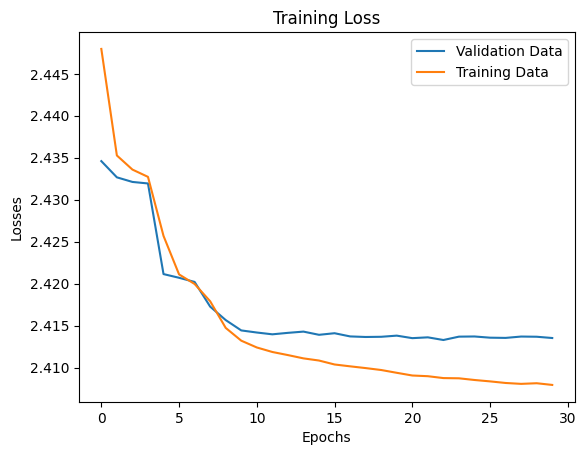

In [ ]:
plt.title("Training Loss")
plt.plot(val_loss_m1,label='Validation Data')
plt.plot(train_loss_m1,label='Training Data')
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.legend()

## Evalute Model

In [ ]:
def predict(model_1,test_dataset,test_tags,device):
  model_1.eval()
  with torch.no_grad():
        pred_test = []
        true_test = []
        for batch_idx_v, (sentences_v, tags_v) in enumerate(test_dataset):
            sentences_v = sentences_v.to(device)
            
            outputs_v = model_1(sentences_v)
            true_test.append(tags_v)
            pred_test.append(torch.argmax(outputs_v,-1))

        true_tags = []
        for i in range(len(true_test)):
          
          test_t = true_test[i]
          tags = [index_tag[int(j)] for j in list(test_t)][-len(test_tags[i]):]
          true_tags.append(tags)

        pred_tags = []
        for i in range(len(pred_test)):
         
          test_p = pred_test[i]
          tags = [index_tag[int(j)] for j in list(test_p)][-len(test_tags[i]):]
          pred_tags.append(tags)

  return true_tags,pred_tags

In [ ]:
true_tags_m1,pred_tags_m1 = predict(model_1,test_dataset,test_tags,device)

## Check Padding

Most of the time our model, is predicted wrong tag means `__padding__`, I try **ignore_index=0,** but  again in prediction we get `__padding__` tag . So to resolve this issue. I remove those sentences, Who's predict `__padding__` tag, because we want f-1 score, and for f-1 score we only need to predict our true labels

In [ ]:
def check_padding(true_tags_m1,pred_tags_m1):
  pred_tags_WOP_m1 = []
  true_tags_WOP_m1 =[]
  for a,i,j in zip(range(len(pred_tags_m1)),pred_tags_m1,true_tags_m1):
    if "__PADDING__" in i:
      print(a)
      pass
    else:
      pred_tags_WOP_m1.append(i)
      true_tags_WOP_m1.append(j)

  return true_tags_WOP_m1,pred_tags_WOP_m1
    
    

Below values is the indexes where we found `__PADDING__` tag we delete this labels from both true test dataset and predicted test dataset

In [ ]:
true_tags_WOP_m1,pred_tags_WOP_m1 = check_padding(true_tags_m1,pred_tags_m1)

Now the dataset is without `__PADDING__` tag. Now is time to calculate f-1 score

In [ ]:
len(true_tags_WOP_m1),len(pred_tags_WOP_m1)

(2000, 2000)

## Confusion Matrix

In [ ]:
def confusion_matrix_multilabel(true_value_lists,pred_value_lists,labels_list):
  y_true = []
  y_pred = []

  for true_values,pred_values in zip(true_value_lists,pred_value_lists):
    for true_value,pred_value in zip(true_values,pred_values):
      y_true.append(true_value)
      y_pred.append(pred_value)


  conf_matrix_v = confusion_matrix(y_true, y_pred)
  conf_matrix = conf_matrix_v.astype('float') / conf_matrix_v.sum(axis=1)[:, np.newaxis]
  fig, ax = plt.subplots(figsize=(10,10))
  sns.heatmap(conf_matrix, annot=True, fmt='.2%', xticklabels=labels_list, yticklabels=labels_list)
  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  plt.show(block=False)

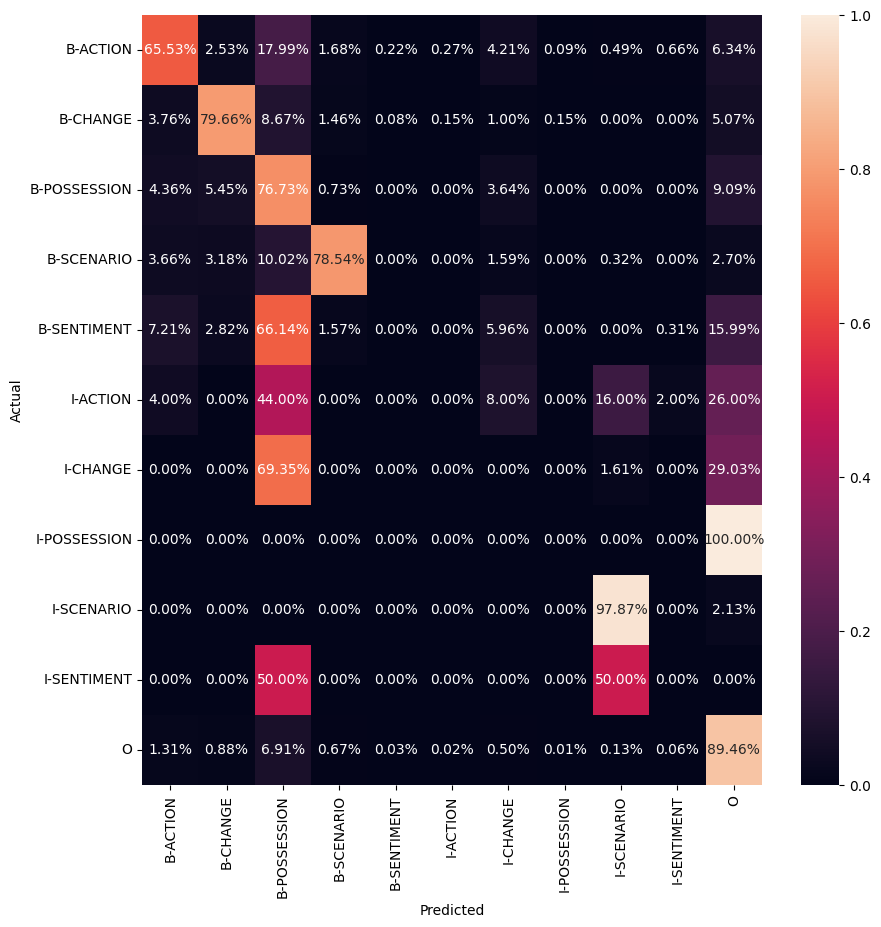

In [ ]:
list_labels = ['B-ACTION', 'B-CHANGE', 'B-POSSESSION', 'B-SCENARIO', 'B-SENTIMENT', 'I-ACTION', 'I-CHANGE', 'I-POSSESSION', 'I-SCENARIO', 'I-SENTIMENT', "O"]
confusion_matrix_multilabel(true_tags_WOP_m1,pred_tags_WOP_m1,list_labels)

## Accuracy of Model

In [ ]:
print(accuracy_score(true_tags_WOP_m1,pred_tags_WOP_m1))

0.872293116782676


## F-1 Score

In [ ]:
print('MODEL-1')
print('='*15)
print(classification_report(true_tags_WOP_m1,pred_tags_WOP_m1))

MODEL-1
              precision    recall  f1-score   support

      ACTION       0.66      0.65      0.65      2257
      CHANGE       0.52      0.76      0.62      1303
  POSSESSION       0.05      0.76      0.09       275
    SCENARIO       0.52      0.79      0.63       629
   SENTIMENT       0.02      0.00      0.01       319

   micro avg       0.33      0.66      0.44      4783
   macro avg       0.35      0.59      0.40      4783
weighted avg       0.52      0.66      0.56      4783



In [ ]:
print('MODEL-1 (Scheme=IOB2')
print('='*15)
print(classification_report(true_tags_WOP_m1,pred_tags_WOP_m1,mode='strict',scheme=IOB2))

MODEL-1 (Scheme=IOB2
              precision    recall  f1-score   support

      ACTION       0.58      0.70      0.63      2257
      CHANGE       0.62      0.74      0.68      1303
  POSSESSION       0.00      0.00      0.00       275
    SCENARIO       0.52      0.85      0.64       629
   SENTIMENT       0.04      0.01      0.02       319

   micro avg       0.57      0.64      0.61      4783
   macro avg       0.35      0.46      0.39      4783
weighted avg       0.51      0.64      0.57      4783



/usr/local/lib/python3.9/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Model 2 (With Pre-trained Word Embedding)

Here I am using pre-trained word embedding model. 

The model arhitecture is same as model1 for better comparasion

```
MODEL_1(
  (embedding_layer): Embedding(33081, 300, padding_idx=0)
  (lstm): LSTM(300, 128, batch_first=True, bidirectional=True)
  (dropout1): Dropout(p=0.4, inplace=False)
  (fc1): Linear(in_features=256, out_features=32, bias=True)
  (dropout2): Dropout(p=0.4, inplace=False)
  (fc2): Linear(in_features=32, out_features=12, bias=True)
  (softmax): Softmax(dim=1)
)
```
I try different hyperparameter tuning technique. Then I finalized above model architecture.



## Download Pre-trained Embedding
Here, I am using ***glove-wiki-gigaword-30***. It's better for our dataset, because our dataset is general english words

In [ ]:
print(list(gensim.downloader.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [ ]:
wv = gensim.downloader.load('glove-wiki-gigaword-300')

[==================================================] 100.0% 376.1/376.1MB downloaded


## Create word embedding Matrix

In ***glove-wiki-gigaword-300*** have 400K vocabs. Most of the vocabs is not usefull because. we need only training dataset vocabs. So we extract embedding for those words. Which are available in our training vocabs. For `__PADDING__` we assign zeros value and for `__UNK__` we assign random values.

It's also take less computional power in our training

In [ ]:

OOV_TOKEN = '__UNK__'


embedding_dim = wv.vector_size
print(embedding_dim)

vocab_embedd = {}
embedding_matrix = np.zeros((len(wv.key_to_index) + 1, embedding_dim))
for i, word in enumerate(wv.key_to_index):
    vocab_embedd[word] = i + 1
    embedding_matrix[i+1] = wv[word]

vocab_embedd[OOV_TOKEN] = 0
embedding_matrix[0] = np.random.rand(embedding_dim)


300


In [ ]:
num_words = VOCAB_SIZE # 1 for padding, other one for UNK
embedding_matrix_for_data = torch.zeros((num_words, embedding_dim))
for i,word in index_vocab.items():
    if word in vocab_embedd:
        embedding_vector = embedding_matrix[vocab_embedd[word]]
        embedding_matrix_for_data[i] = torch.tensor(embedding_vector)
    else:
        embedding_matrix_for_data[i] = torch.tensor(embedding_matrix[0])

In [ ]:
embedding_matrix_for_data.shape

torch.Size([33081, 300])

In [ ]:
wv.vector_size

300

## Build Model

In [ ]:
class MODEL_2(nn.Module):
  
  def __init__(self, hidden_dim, output_dim,embedding_dim,dropout_value,weight):
    super(MODEL_2, self).__init__()
    self.hidden_size = hidden_dim
    self.output_size = output_dim

    self.embedding_layer =torch.nn.Embedding.from_pretrained(embedding_matrix_for_data,padding_idx=0,freeze=False)
    
    self.lstm = nn.LSTM(input_size=embedding_dim,
    hidden_size=hidden_dim,
    num_layers=1,
    bidirectional=True,
    batch_first=True)
    self.dropout1 = nn.Dropout(p=dropout_value)
    self.fc1 = nn.Linear(hidden_dim*2, 32)
    self.dropout2 = nn.Dropout(p=dropout_value)
    self.fc2 = nn.Linear(32, output_dim)
    self.softmax = nn.Softmax(dim=1)

  def forward(self, input):
    embedded_sequences = self.embedding_layer(input)
    lstm_output, _ = self.lstm(embedded_sequences)
    x = self.dropout1(lstm_output)
    x = self.fc1(x)
    x = nn.Tanh()(x)
    x = self.dropout2(x)
    x = self.fc2(x)
    preds = self.softmax(x)
    return preds


## Build Training Loop

In [ ]:
def training_loop_2(model,train_dataloader,val_dataloader,loss_function,optimizer,num_epochs,model_save,device=device):
  training_loss = []
  validation_loss = []
  for epoch in range(num_epochs):
    losses = []
    model.train()
    for batch_idx, (inputs, targets) in enumerate(tqdm(train_dataloader, unit="batch", total=len(train_dataloader))):
    
      inputs = inputs.to(device)
      
      targets = targets.view(-1).long().to(device)
   
      optimizer.zero_grad()

      outputs = model(inputs)
      outputs = outputs.view(-1, outputs.shape[-1])
   
      loss = loss_function(outputs,targets)
      losses.append(loss)
      loss.backward()
      optimizer.step()

      if batch_idx % 100 == 0 and batch_idx != 0:
        
        if model_save == True:
          path = 'Model/'
          torch.save(model.state_dict(), f'{path}model_checkpoint_epoch-{epoch}+{batch_idx}.pth')

    mean_loss = sum(losses) / len(losses)
    training_loss.append(mean_loss.item())

    

    print('')
    sleep(0.01)
    print(f"Training Epoch {epoch+1} ==========> Training loss: {mean_loss:0.6f}")


    model.eval()
    with torch.no_grad():
     
      losses_v = []
      for batch_idx_v, (sentences_v, tags_v) in enumerate(val_dataloader):
          sleep(0.01)
          sentences_v = sentences_v.to(device)
         
          tags_v=tags_v.view(-1).long().to(device)
          
          outputs_v = model(sentences_v)
          outputs_v = outputs_v.view(-1, outputs_v.shape[-1])
         
          vloss = loss_function(outputs_v,tags_v)
          losses_v.append(vloss)
      mean_loss_v = sum(losses_v) / len(losses_v)
      validation_loss.append(float(mean_loss_v))
    
    print(f"Validation Epoch {epoch+1} ==========> Validation loss: {mean_loss_v:0.6f}")
    print('')

  return training_loss,validation_loss

## Define Hyperparameters

In [ ]:
dropout_value = 0.4
denselayer_dim = 32
embedding_dim = embedding_dim
hidden_dim = 128
output_dim = len(index_tag)
num_epochs = 25
weight =embedding_matrix_for_data

In [ ]:
model_2 = MODEL_2(hidden_dim=hidden_dim, output_dim=output_dim,embedding_dim=embedding_dim,dropout_value=dropout_value,weight=weight).to(device)
optimizer = optim.Adam(model_2.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(ignore_index=0)

In [ ]:
model_2

MODEL_2(
  (embedding_layer): Embedding(33081, 300, padding_idx=0)
  (lstm): LSTM(300, 128, batch_first=True, bidirectional=True)
  (dropout1): Dropout(p=0.4, inplace=False)
  (fc1): Linear(in_features=256, out_features=32, bias=True)
  (dropout2): Dropout(p=0.4, inplace=False)
  (fc2): Linear(in_features=32, out_features=12, bias=True)
  (softmax): Softmax(dim=1)
)

## Training Model

In [ ]:
train_loss_m2,val_loss_m2 = training_loop_2(
    model_2,
    train_dataloader,
    val_dataloader,
    criterion,optimizer,
    num_epochs,
    False,
    device
    )

100%|██████████| 625/625 [00:06<00:00, 90.38batch/s]



Training Epoch 1 ==========> Training loss: 2.440606
Validation Epoch 1 ==========> Validation loss: 2.432211



100%|██████████| 625/625 [00:06<00:00, 96.83batch/s]



Training Epoch 2 ==========> Training loss: 2.427276
Validation Epoch 2 ==========> Validation loss: 2.420332



100%|██████████| 625/625 [00:06<00:00, 96.08batch/s]



Training Epoch 3 ==========> Training loss: 2.419831
Validation Epoch 3 ==========> Validation loss: 2.419687



100%|██████████| 625/625 [00:06<00:00, 96.28batch/s]



Training Epoch 4 ==========> Training loss: 2.418681
Validation Epoch 4 ==========> Validation loss: 2.419569



100%|██████████| 625/625 [00:06<00:00, 94.38batch/s]



Training Epoch 5 ==========> Training loss: 2.417970
Validation Epoch 5 ==========> Validation loss: 2.419487



100%|██████████| 625/625 [00:06<00:00, 97.19batch/s]



Training Epoch 6 ==========> Training loss: 2.415287
Validation Epoch 6 ==========> Validation loss: 2.413631



100%|██████████| 625/625 [00:06<00:00, 95.91batch/s]



Training Epoch 7 ==========> Training loss: 2.411129
Validation Epoch 7 ==========> Validation loss: 2.413091



100%|██████████| 625/625 [00:06<00:00, 97.79batch/s]



Training Epoch 8 ==========> Training loss: 2.410348
Validation Epoch 8 ==========> Validation loss: 2.413278



100%|██████████| 625/625 [00:06<00:00, 96.32batch/s]



Training Epoch 9 ==========> Training loss: 2.409807
Validation Epoch 9 ==========> Validation loss: 2.413417



100%|██████████| 625/625 [00:06<00:00, 98.49batch/s]



Training Epoch 10 ==========> Training loss: 2.409310
Validation Epoch 10 ==========> Validation loss: 2.413143



100%|██████████| 625/625 [00:06<00:00, 96.38batch/s]



Training Epoch 11 ==========> Training loss: 2.409017
Validation Epoch 11 ==========> Validation loss: 2.413282



100%|██████████| 625/625 [00:06<00:00, 98.29batch/s]



Training Epoch 12 ==========> Training loss: 2.408692
Validation Epoch 12 ==========> Validation loss: 2.413272



100%|██████████| 625/625 [00:06<00:00, 97.08batch/s]



Training Epoch 13 ==========> Training loss: 2.408435
Validation Epoch 13 ==========> Validation loss: 2.413365



100%|██████████| 625/625 [00:06<00:00, 97.76batch/s]



Training Epoch 14 ==========> Training loss: 2.408149
Validation Epoch 14 ==========> Validation loss: 2.413696



100%|██████████| 625/625 [00:06<00:00, 97.08batch/s]



Training Epoch 15 ==========> Training loss: 2.407850
Validation Epoch 15 ==========> Validation loss: 2.413351



100%|██████████| 625/625 [00:06<00:00, 96.81batch/s]



Training Epoch 16 ==========> Training loss: 2.407774
Validation Epoch 16 ==========> Validation loss: 2.413298



100%|██████████| 625/625 [00:06<00:00, 97.60batch/s]



Training Epoch 17 ==========> Training loss: 2.407627
Validation Epoch 17 ==========> Validation loss: 2.413199



100%|██████████| 625/625 [00:06<00:00, 95.78batch/s]



Training Epoch 18 ==========> Training loss: 2.407374
Validation Epoch 18 ==========> Validation loss: 2.413470



100%|██████████| 625/625 [00:06<00:00, 97.53batch/s]



Training Epoch 19 ==========> Training loss: 2.407329
Validation Epoch 19 ==========> Validation loss: 2.413669



100%|██████████| 625/625 [00:06<00:00, 95.88batch/s]



Training Epoch 20 ==========> Training loss: 2.407156
Validation Epoch 20 ==========> Validation loss: 2.413937



100%|██████████| 625/625 [00:06<00:00, 97.78batch/s]



Training Epoch 21 ==========> Training loss: 2.407049
Validation Epoch 21 ==========> Validation loss: 2.414137



100%|██████████| 625/625 [00:06<00:00, 95.60batch/s]



Training Epoch 22 ==========> Training loss: 2.406941
Validation Epoch 22 ==========> Validation loss: 2.413736



100%|██████████| 625/625 [00:06<00:00, 98.06batch/s]



Training Epoch 23 ==========> Training loss: 2.406827
Validation Epoch 23 ==========> Validation loss: 2.413927



100%|██████████| 625/625 [00:06<00:00, 96.42batch/s]



Training Epoch 24 ==========> Training loss: 2.406767
Validation Epoch 24 ==========> Validation loss: 2.413984



100%|██████████| 625/625 [00:06<00:00, 98.06batch/s]



Training Epoch 25 ==========> Training loss: 2.406653
Validation Epoch 25 ==========> Validation loss: 2.413767



## Visualize Training and Validation lossess

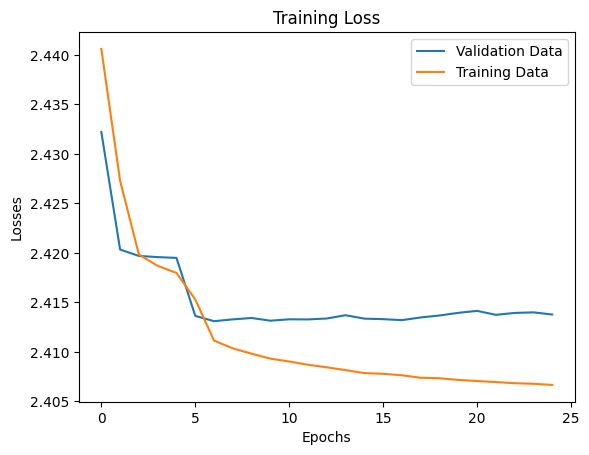

In [ ]:
plt.title("Training Loss")
plt.plot(val_loss_m2,label='Validation Data')
plt.plot(train_loss_m2,label='Training Data')
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.legend()

## Evalute Model

In [ ]:
def predict(model_2,test_dataset,test_tags,device):
  model_2.eval()
  with torch.no_grad():
        pred_test = []
        true_test = []
        for batch_idx_v, (sentences_v, tags_v) in enumerate(test_dataset):
            sentences_v = sentences_v.to(device)
           
            outputs_v = model_2(sentences_v)
            true_test.append(tags_v)
            pred_test.append(torch.argmax(outputs_v,-1))

        true_tags = []
        for i in range(len(true_test)):
       
          test_t = true_test[i]
          tags = [index_tag[int(j)] for j in list(test_t)][-len(test_tags[i]):]
          true_tags.append(tags)

        pred_tags = []
        for i in range(len(pred_test)):
    
          test_p = pred_test[i]
          tags = [index_tag[int(j)] for j in list(test_p)][-len(test_tags[i]):]
          pred_tags.append(tags)

  return true_tags,pred_tags

In [ ]:
true_tags_m2,pred_tags_m2 = predict(model_2,test_dataset,test_tags,device)

## Check Padding

In [ ]:
def check_padding(true_tags_m2,pred_tags_m2):
  pred_tags_WOP_m2 = []
  true_tags_WOP_m2 =[]
  for a,i,j in zip(range(len(pred_tags_m2)),pred_tags_m2,true_tags_m2):
    if "__PADDING__" in i:
      print(a)
      pass
    else:
      pred_tags_WOP_m2.append(i)
      true_tags_WOP_m2.append(j)

  return true_tags_WOP_m2,pred_tags_WOP_m2
    
    

In [ ]:
true_tags_WOP_m2,pred_tags_WOP_m2 = check_padding(true_tags_m2,pred_tags_m2)

In [ ]:
len(true_tags_WOP_m2),len(pred_tags_WOP_m2)

(2000, 2000)

## Confusion Matrix

In [ ]:
def confusion_matrix_multilabel(true_value_lists,pred_value_lists,labels_list):
  y_true = []
  y_pred = []

  for true_values,pred_values in zip(true_value_lists,pred_value_lists):
    for true_value,pred_value in zip(true_values,pred_values):
      y_true.append(true_value)
      y_pred.append(pred_value)


  conf_matrix_v = confusion_matrix(y_true, y_pred)
  conf_matrix = conf_matrix_v.astype('float') / conf_matrix_v.sum(axis=1)[:, np.newaxis]
  fig, ax = plt.subplots(figsize=(10,10))
  sns.heatmap(conf_matrix, annot=True, fmt='.2%', xticklabels=labels_list, yticklabels=labels_list)
  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  plt.show(block=False)

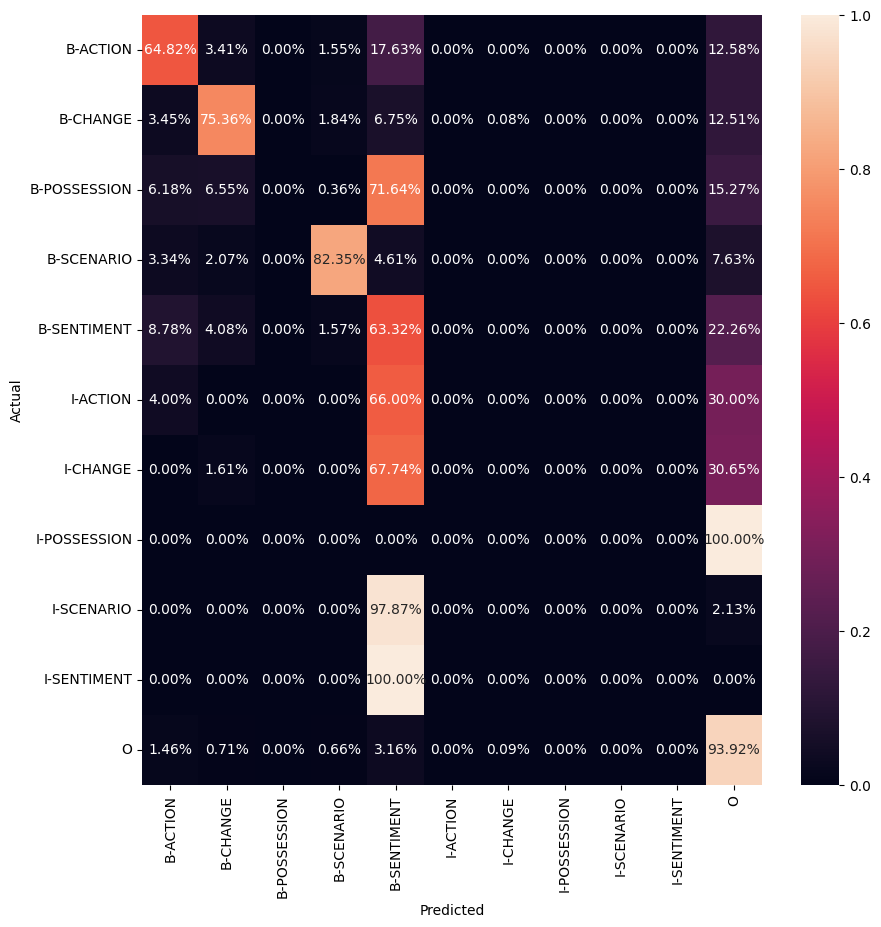

In [ ]:
list_labels = ['B-ACTION', 'B-CHANGE', 'B-POSSESSION', 'B-SCENARIO', 'B-SENTIMENT', 'I-ACTION', 'I-CHANGE', 'I-POSSESSION', 'I-SCENARIO', 'I-SENTIMENT', "O"]
confusion_matrix_multilabel(true_tags_WOP_m2,pred_tags_WOP_m2,list_labels)

## Accuracy of Model

In [ ]:
print(accuracy_score(true_tags_WOP_m2,pred_tags_WOP_m2))

0.9105761794276875


## F-1 Score

In [ ]:
print('MODEL-2')
print('='*15)
print(classification_report(true_tags_WOP_m2,pred_tags_WOP_m2))

MODEL-2


/usr/local/lib/python3.9/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

      ACTION       0.64      0.64      0.64      2257
      CHANGE       0.63      0.72      0.67      1303
  POSSESSION       0.00      0.00      0.00       275
    SCENARIO       0.53      0.75      0.62       629
   SENTIMENT       0.08      0.63      0.14       319

   micro avg       0.43      0.64      0.51      4783
   macro avg       0.38      0.55      0.41      4783
weighted avg       0.55      0.64      0.58      4783



In [ ]:
print('MODEL-2 (Scheme=IOB2')
print('='*15)
print(classification_report(true_tags_WOP_m2,pred_tags_WOP_m2,mode='strict',scheme=IOB2))

MODEL-2 (Scheme=IOB2
              precision    recall  f1-score   support

      ACTION       0.64      0.64      0.64      2257
      CHANGE       0.65      0.72      0.68      1303
  POSSESSION       0.00      0.00      0.00       275
    SCENARIO       0.53      0.75      0.62       629
   SENTIMENT       0.08      0.63      0.14       319

   micro avg       0.43      0.64      0.51      4783
   macro avg       0.38      0.55      0.42      4783
weighted avg       0.55      0.64      0.58      4783



# Model 3 Conditional random fields (CRF) + BiLSTM

For the token classification, conditional random fields (CRF) + BiLSTM are among the most widely used models.

## Build Model

In [ ]:
def argmax(vector):
    
    _, index = torch.max(vector, 1)
    return index.item()


def log_sum_exp(vector):
    maximum_score = vector[0, argmax(vector)]
    maximum_score_broadcast = maximum_score.view(1, -1).expand(1, vector.size()[1])
    return maximum_score + \
        torch.log(torch.sum(torch.exp(vector - maximum_score_broadcast).to(device)).to(device))

In [ ]:
START_TAG = "<START>"
STOP_TAG = "<STOP>"

In [ ]:
class Model3_CRF(nn.Module):

    def __init__(self, vocab_size, tag_to_ix, embedding_dim, hidden_dim):
        super(Model3_CRF, self).__init__()
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.tag_to_ix = tag_to_ix
        self.tagset_size = len(tag_to_ix)

        self.word_embeds = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim // 2,
                            num_layers=1, bidirectional=True)

        
        self.hidden2tag = nn.Linear(hidden_dim, self.tagset_size)

        
        self.transitions = nn.Parameter(
            torch.randn(self.tagset_size, self.tagset_size)).to(device)

        
        self.transitions.data[tag_to_ix[START_TAG], :] = -10000
        self.transitions.data[:, tag_to_ix[STOP_TAG]] = -10000

        self.hidden = self.init_hidden()

    def init_hidden(self):
        return (torch.randn(2, 1, self.hidden_dim // 2).to(device),
                torch.randn(2, 1, self.hidden_dim // 2).to(device))

    def _forward_alg(self, feats):
        
        init_alphas = torch.full((1, self.tagset_size), -10000.).to(device)
        
        init_alphas[0][self.tag_to_ix[START_TAG]] = 0.

        
        forward_var = init_alphas

        
        for feat in feats:
            alphas_t = []  
            for next_tag in range(self.tagset_size):
                
                emit_score = feat[next_tag].view(
                    1, -1).expand(1, self.tagset_size)
                
                trans_score = self.transitions[next_tag].view(1, -1)
                
                next_tag_var = forward_var + trans_score + emit_score
                
                alphas_t.append(log_sum_exp(next_tag_var).view(1))
            forward_var = torch.cat(alphas_t).view(1, -1).to(device)
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        alpha = log_sum_exp(terminal_var)
        return alpha

    def _get_lstm_features(self, sentence):
        self.hidden = self.init_hidden()
        embeds = self.word_embeds(sentence).view(len(sentence), 1, -1)
        lstm_out, self.hidden = self.lstm(embeds, self.hidden)
        lstm_out = lstm_out.view(len(sentence), self.hidden_dim)
        lstm_feats = self.hidden2tag(lstm_out)
        return lstm_feats

    def _score_sentence(self, feats, tags):
        
        score = torch.zeros(1).to(device)
        tags = torch.cat([torch.tensor([self.tag_to_ix[START_TAG]], dtype=torch.long).to(device), tags])
        for i, feat in enumerate(feats):
            score = score + \
                self.transitions[tags[i + 1], tags[i]] + feat[tags[i + 1]]
        score = score + self.transitions[self.tag_to_ix[STOP_TAG], tags[-1]]
        return score

    def _viterbi_decode(self, feats):
        backpointers = []

        
        init_vvars = torch.full((1, self.tagset_size), -10000.).to(device)
        init_vvars[0][self.tag_to_ix[START_TAG]] = 0

        
        forward_var = init_vvars
        for feat in feats:
            bptrs_t = []  
            viterbivars_t = []  

            for next_tag in range(self.tagset_size):
                
                next_tag_var = forward_var + self.transitions[next_tag]
                best_tag_id = argmax(next_tag_var)
                bptrs_t.append(best_tag_id)
                viterbivars_t.append(next_tag_var[0][best_tag_id].view(1))
            
            forward_var = (torch.cat(viterbivars_t) + feat).view(1, -1).to(device)
            backpointers.append(bptrs_t)

        
        terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
        best_tag_id = argmax(terminal_var)
        path_score = terminal_var[0][best_tag_id]

        
        best_path = [best_tag_id]
        for bptrs_t in reversed(backpointers):
            best_tag_id = bptrs_t[best_tag_id]
            best_path.append(best_tag_id)
        
        start = best_path.pop()
        assert start == self.tag_to_ix[START_TAG]  
        best_path.reverse()
        return path_score, best_path

    def neg_log_likelihood(self, sentence, tags):
        feats = self._get_lstm_features(sentence)
        forward_score = self._forward_alg(feats)
        gold_score = self._score_sentence(feats, tags)
        return forward_score - gold_score

    def forward(self, sentence):  
        lstm_feats = self._get_lstm_features(sentence)

        
        score, tag_seq = self._viterbi_decode(lstm_feats)
        return score, tag_seq

In [ ]:
tag_to_ix = tags_tokenizer

In [ ]:
tag_to_ix["<START>"]=12
tag_to_ix["<STOP>"]=13

## Build Training Loop

In [ ]:
def training_loop_3(model,train_dataloader,val_dataloader,optimizer,num_epochs,model_save,path,device=device):
  
  for epoch in range(num_epochs):
    running_loss = 0.0
    model.train()
    for batch_idx, (inputs, targets) in enumerate(train_dataloader):
     
      optimizer.zero_grad()

      loss = model.neg_log_likelihood(inputs.to(device), targets.to(device))
      
      loss.backward()
      optimizer.step()
      running_loss += loss.item()

      if batch_idx % 100 == 0 and batch_idx != 0:
        print(f"Epoch {epoch+1}, Batch {batch_idx}, Loss {loss.item():.4f}")
        if model_save == True:
          torch.save(model.state_dict(), f'{path}model_checkpoint_epoch-{epoch}+{batch_idx}.pth')

    

    
    

    print('')
    print(f"Epoch ==========> {epoch+1} loss: {running_loss/len(train_dataloader)}")


    model.eval()
    with torch.no_grad():
  
      running_vloss = 0.0
      for batch_idx_v, (sentences_v, tags_v) in enumerate(val_dataloader):
          
     
          
          vloss = model.neg_log_likelihood(sentences_v.to(device), tags_v.to(device))

        
          running_vloss += vloss
    
    print(f"    Validation => Epoch{epoch+1} loss: {running_vloss/len(val_dataloader)}")
    print('')

## Define Hyperparameter

In [ ]:
VOCAB_SIZE = len(vocabs) + 2 # 2 is (UNK, PADDING) values

In [ ]:

vocab_size = VOCAB_SIZE
embedding_dim = 100
hidden_dim = 128
learning_rate = 0.01
num_epochs = 2


In [ ]:

model_3 = Model3_CRF(vocab_size, tag_to_ix, embedding_dim, hidden_dim).to(device)
optimizer = optim.Adam(model_3.parameters(), lr=learning_rate)
model_3.train()

Model3_CRF(
  (word_embeds): Embedding(33081, 100)
  (lstm): LSTM(100, 64, bidirectional=True)
  (hidden2tag): Linear(in_features=128, out_features=14, bias=True)
)

## Training Model

In [ ]:
train_loss_m3,val_loss_m3 = training_loop_3(
    model_3,
    train_dataset,
    val_dataset,
    optimizer,
    num_epochs,
    True,
    '/content/drive/MyDrive/MODEL_CHECKPOINTS/',
    device
    )

Epoch 1, Batch 100, Loss 10.8484
Epoch 1, Batch 200, Loss 9.7147
Epoch 1, Batch 300, Loss 2.5558
Epoch 1, Batch 400, Loss 4.3447
Epoch 1, Batch 500, Loss 21.8987
Epoch 1, Batch 600, Loss 11.5844
Epoch 1, Batch 700, Loss 17.6594
Epoch 1, Batch 800, Loss 3.2544
Epoch 1, Batch 900, Loss 3.9391
Epoch 1, Batch 1000, Loss 12.6263
Epoch 1, Batch 1100, Loss 12.9556
Epoch 1, Batch 1200, Loss 3.4330
Epoch 1, Batch 1300, Loss 0.0548
Epoch 1, Batch 1400, Loss 0.7101
Epoch 1, Batch 1500, Loss 0.7849
Epoch 1, Batch 1600, Loss 2.6714
Epoch 1, Batch 1700, Loss 1.8289
Epoch 1, Batch 1800, Loss 7.3379
Epoch 1, Batch 1900, Loss 1.6891
Epoch 1, Batch 2000, Loss 2.7334
Epoch 1, Batch 2100, Loss 3.0452
Epoch 1, Batch 2200, Loss 11.1600
Epoch 1, Batch 2300, Loss 9.1453
Epoch 1, Batch 2400, Loss 14.4399
Epoch 1, Batch 2500, Loss 19.7512
Epoch 1, Batch 2600, Loss 9.4230
Epoch 1, Batch 2700, Loss 8.3966
Epoch 1, Batch 2800, Loss 7.8608
Epoch 1, Batch 2900, Loss 1.8657
Epoch 1, Batch 3000, Loss 11.8265
Epoch 1, 

## Evalute Model

### Build instance of your trained model

In [ ]:
VOCAB_SIZE = len(vocabs) + 2 # 2 is (UNK, PADDING) values

In [ ]:

vocab_size = VOCAB_SIZE
embedding_dim = 100
hidden_dim = 128
learning_rate = 0.01
num_epochs = 2


In [ ]:

model_3 = Model3_CRF(vocab_size, tag_to_ix, embedding_dim, hidden_dim).to(device)
optimizer = optim.Adam(model_3.parameters(), lr=learning_rate)

In [ ]:
model_3.load_state_dict(torch.load('/content/drive/MyDrive/MODEL_CHECKPOINTS/model_checkpoint_epoch-1+7800.pth'),strict=True)
model_3.eval()

Model3_CRF(
  (word_embeds): Embedding(33081, 100)
  (lstm): LSTM(100, 64, bidirectional=True)
  (hidden2tag): Linear(in_features=128, out_features=14, bias=True)
)

In [ ]:
def predict(model_3,test_dataset,test_tags,device):
  with torch.no_grad():
        pred_test = []
        true_test = []
        for batch_idx_v, (sentences_v, tags_v) in enumerate(test_dataset):
            sentences_v = sentences_v.to(device)
            
            outputs_v = model_3(sentences_v)
            true_test.append(tags_v)
            pred_test.append(outputs_v)

        true_tags = []
        for i in range(len(true_test)):
         
          test_t = true_test[i]
          tags = [index_tag[int(j)] for j in list(test_t)][-len(test_tags[i]):]
          true_tags.append(tags)

        pred_tags = []
        for i in range(len(pred_test)):
        
          test_p = pred_test[i][1]
          tags = [index_tag[int(j)] for j in list(test_p)][-len(test_tags[i]):]
          pred_tags.append(tags)

  return true_tags,pred_tags

In [ ]:
true_tags_m3,pred_tags_m3 = predict(model_3,test_dataset,test_tags,device)

## Check Padding

In [ ]:
def check_padding(true_tags_m3,pred_tags_m3):
  pred_tags_WOP_m3 = []
  true_tags_WOP_m3 =[]
  for a,i,j in zip(range(len(pred_tags_m3)),pred_tags_m3,true_tags_m3):
    if "__PADDING__" in i:
      print(a)
      pass
    else:
      pred_tags_WOP_m3.append(i)
      true_tags_WOP_m3.append(j)

  return true_tags_WOP_m3,pred_tags_WOP_m3
    
    

**You can see that. Now the model predict accurate result not `__padding__`**

In [ ]:
true_tags_WOP_m3,pred_tags_WOP_m3 = check_padding(true_tags_m3,pred_tags_m3)

In [ ]:
len(true_tags_WOP_m3),len(pred_tags_WOP_m3)

(2000, 2000)

## Confusion Matrix

In [ ]:
def confusion_matrix_multilabel(true_value_lists,pred_value_lists,labels_list):
  y_true = []
  y_pred = []

  for true_values,pred_values in zip(true_value_lists,pred_value_lists):
    for true_value,pred_value in zip(true_values,pred_values):
      y_true.append(true_value)
      y_pred.append(pred_value)


  conf_matrix_v = confusion_matrix(y_true, y_pred)
  conf_matrix = conf_matrix_v.astype('float') / conf_matrix_v.sum(axis=1)[:, np.newaxis]
  fig, ax = plt.subplots(figsize=(10,10))
  sns.heatmap(conf_matrix, annot=True, fmt='.2%', xticklabels=labels_list, yticklabels=labels_list)
  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  plt.show(block=False)

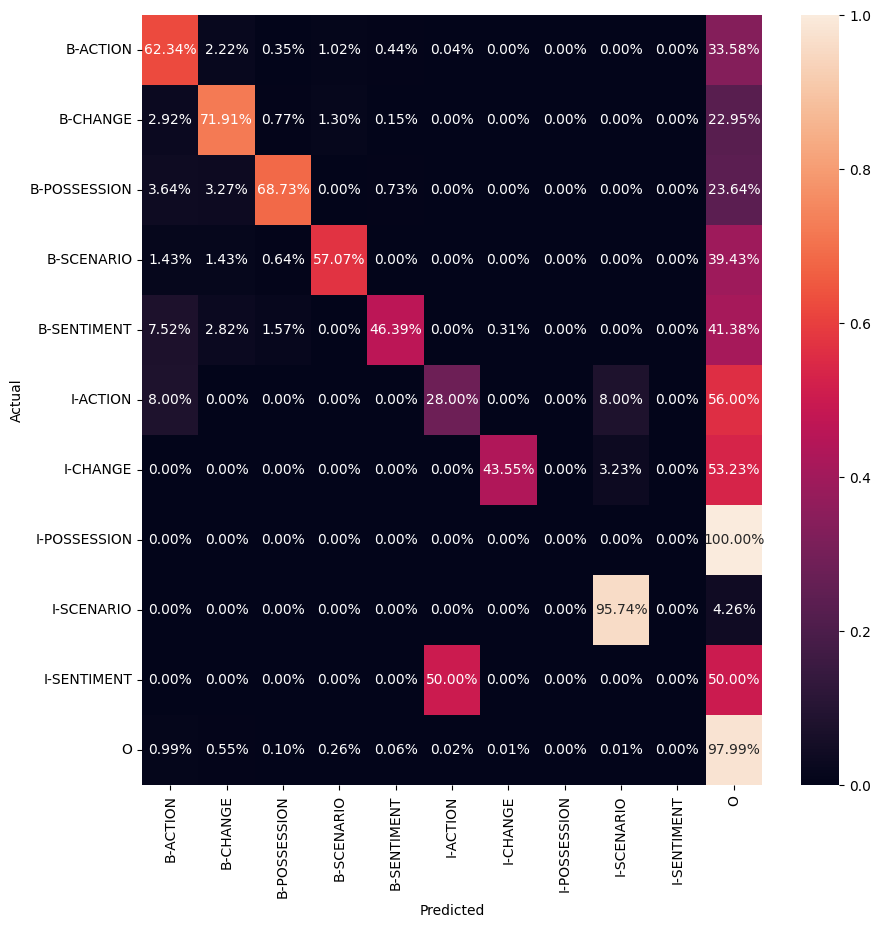

In [ ]:
list_labels = ['B-ACTION', 'B-CHANGE', 'B-POSSESSION', 'B-SCENARIO', 'B-SENTIMENT', 'I-ACTION', 'I-CHANGE', 'I-POSSESSION', 'I-SCENARIO', 'I-SENTIMENT', "O"]
confusion_matrix_multilabel(true_tags_WOP_m3,pred_tags_WOP_m3,list_labels)

## Accuracy of Model

In [ ]:
print(accuracy_score(true_tags_WOP_m3,pred_tags_WOP_m3))

0.9466744006187162


## F-1 Score

In [ ]:
print('MODEL-3')
print('='*15)
print(classification_report(true_tags_WOP_m3,pred_tags_WOP_m3))

MODEL-3
              precision    recall  f1-score   support

      ACTION       0.71      0.62      0.66      2257
      CHANGE       0.73      0.71      0.72      1303
  POSSESSION       0.71      0.68      0.70       275
    SCENARIO       0.69      0.57      0.62       629
   SENTIMENT       0.77      0.46      0.58       319

   micro avg       0.72      0.63      0.67      4783
   macro avg       0.72      0.61      0.66      4783
weighted avg       0.72      0.63      0.67      4783



In [ ]:
print('MODEL-3 (Scheme=IOB2')
print('='*15)
print(classification_report(true_tags_WOP_m3,pred_tags_WOP_m3,mode='strict',scheme=IOB2))

MODEL-3 (Scheme=IOB2
              precision    recall  f1-score   support

      ACTION       0.71      0.62      0.66      2257
      CHANGE       0.73      0.71      0.72      1303
  POSSESSION       0.71      0.68      0.70       275
    SCENARIO       0.69      0.57      0.62       629
   SENTIMENT       0.77      0.46      0.58       319

   micro avg       0.72      0.63      0.67      4783
   macro avg       0.72      0.61      0.66      4783
weighted avg       0.72      0.63      0.67      4783



**You can see that our model give much high F1 score in 2 epochs. Now we train this trained model again for 2 epochs. To check weather our f1 score will increase or decrease**

# Again Training Model 3

In [ ]:
VOCAB_SIZE = len(vocabs) + 2 # 2 is (UNK, PADDING) values

In [ ]:

vocab_size = VOCAB_SIZE
embedding_dim = 100
hidden_dim = 128
learning_rate = 0.01
num_epochs = 2


In [ ]:

model_3 = Model3_CRF(vocab_size, tag_to_ix, embedding_dim, hidden_dim).to(device)
optimizer = optim.Adam(model_3.parameters(), lr=learning_rate)

In [ ]:
model_3.load_state_dict(torch.load('/content/drive/MyDrive/MODEL_CHECKPOINTS/model_checkpoint_epoch-1+7800.pth'),strict=True)
model_3.train()

Model3_CRF(
  (word_embeds): Embedding(33081, 100)
  (lstm): LSTM(100, 64, bidirectional=True)
  (hidden2tag): Linear(in_features=128, out_features=14, bias=True)
)

In [ ]:
train_loss_m3_update,val_loss_m3_update = training_loop_3(
    model_3,
    train_dataset,
    val_dataset,
    optimizer,
    num_epochs,
    True,
    '/content/drive/MyDrive/MODEL_CHECKPOINTS/Model_Training2_Checkpoints/',
    device
    )

Epoch 1, Batch 100, Loss 0.2025
Epoch 1, Batch 200, Loss 1.3710
Epoch 1, Batch 300, Loss 1.0546
Epoch 1, Batch 400, Loss 4.6632
Epoch 1, Batch 500, Loss 4.5758
Epoch 1, Batch 600, Loss 6.1085
Epoch 1, Batch 700, Loss 6.5589
Epoch 1, Batch 800, Loss 0.3546
Epoch 1, Batch 900, Loss 1.8790
Epoch 1, Batch 1000, Loss 4.7250
Epoch 1, Batch 1100, Loss 21.9343
Epoch 1, Batch 1200, Loss 3.2930
Epoch 1, Batch 1300, Loss 0.1194
Epoch 1, Batch 1400, Loss 0.1465
Epoch 1, Batch 1500, Loss 0.1394
Epoch 1, Batch 1600, Loss 0.5723
Epoch 1, Batch 1700, Loss 0.7389
Epoch 1, Batch 1800, Loss 4.4047
Epoch 1, Batch 1900, Loss 0.1428
Epoch 1, Batch 2000, Loss 0.7386
Epoch 1, Batch 2100, Loss 2.4130
Epoch 1, Batch 2200, Loss 8.1782
Epoch 1, Batch 2300, Loss 5.7531
Epoch 1, Batch 2400, Loss 7.4475
Epoch 1, Batch 2500, Loss 17.5987
Epoch 1, Batch 2600, Loss 10.1602
Epoch 1, Batch 2700, Loss 6.4165
Epoch 1, Batch 2800, Loss 4.6203
Epoch 1, Batch 2900, Loss 0.8961
Epoch 1, Batch 3000, Loss 10.3911
Epoch 1, Batch 

In [ ]:
VOCAB_SIZE = len(vocabs) + 2 # 2 is (UNK, PADDING) values

In [ ]:

vocab_size = VOCAB_SIZE
embedding_dim = 100
hidden_dim = 128
learning_rate = 0.01
num_epochs = 1


In [ ]:

model_3_check = Model3_CRF(vocab_size, tag_to_ix, embedding_dim, hidden_dim).to(device)
optimizer = optim.Adam(model_3_check.parameters(), lr=learning_rate)

In [ ]:
model_3_check.load_state_dict(torch.load('/content/drive/MyDrive/MODEL_CHECKPOINTS/Model_Training2_Checkpoints/model_checkpoint_epoch-0+19900.pth'),strict=True)
model_3_check.eval()

Model3_CRF(
  (word_embeds): Embedding(33081, 100)
  (lstm): LSTM(100, 64, bidirectional=True)
  (hidden2tag): Linear(in_features=128, out_features=14, bias=True)
)

In [ ]:
def predict(model_3,test_dataset,test_tags,device):
  with torch.no_grad():
        pred_test = []
        true_test = []
        for batch_idx_v, (sentences_v, tags_v) in enumerate(test_dataset):
            sentences_v = sentences_v.to(device)
           
            outputs_v = model_3(sentences_v)
            true_test.append(tags_v)
            pred_test.append(outputs_v)

        true_tags = []
        for i in range(len(true_test)):
         
          test_t = true_test[i]
          tags = [index_tag[int(j)] for j in list(test_t)][-len(test_tags[i]):]
          true_tags.append(tags)

        pred_tags = []
        for i in range(len(pred_test)):
      
          test_p = pred_test[i][1]
          tags = [index_tag[int(j)] for j in list(test_p)][-len(test_tags[i]):]
          pred_tags.append(tags)

  return true_tags,pred_tags

In [ ]:
true_tags_m3,pred_tags_m3 = predict(model_3_check,test_dataset,test_tags,device)

## Check Padding

In [ ]:
def check_padding(true_tags_m3,pred_tags_m3):
  pred_tags_WOP_m3 = []
  true_tags_WOP_m3 =[]
  for a,i,j in zip(range(len(pred_tags_m3)),pred_tags_m3,true_tags_m3):
    if "__PADDING__" in i:
      print(a)
      pass
    else:
      pred_tags_WOP_m3.append(i)
      true_tags_WOP_m3.append(j)

  return true_tags_WOP_m3,pred_tags_WOP_m3
    
    

**You can see that. Now the model predict `__padding__`** in testing dataset

In [ ]:
true_tags_WOP_m3,pred_tags_WOP_m3 = check_padding(true_tags_m3,pred_tags_m3)

1519


In [ ]:
len(true_tags_WOP_m3),len(pred_tags_WOP_m3)

(1999, 1999)

## Confusion Matrix

In [ ]:
def confusion_matrix_multilabel(true_value_lists,pred_value_lists,labels_list):
  y_true = []
  y_pred = []

  for true_values,pred_values in zip(true_value_lists,pred_value_lists):
    for true_value,pred_value in zip(true_values,pred_values):
      y_true.append(true_value)
      y_pred.append(pred_value)


  conf_matrix_v = confusion_matrix(y_true, y_pred)
  conf_matrix = conf_matrix_v.astype('float') / conf_matrix_v.sum(axis=1)[:, np.newaxis]
  fig, ax = plt.subplots(figsize=(10,10))
  sns.heatmap(conf_matrix, annot=True, fmt='.2%', xticklabels=labels_list, yticklabels=labels_list)
  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  plt.show(block=False)

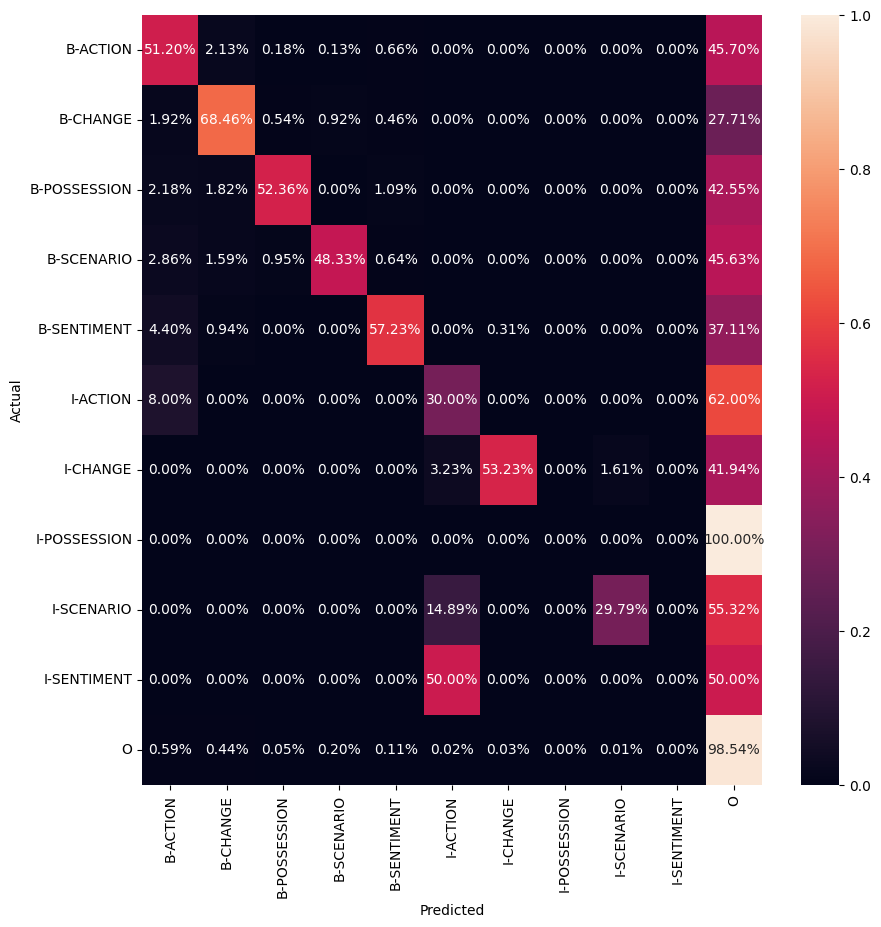

In [ ]:
list_labels = ['B-ACTION', 'B-CHANGE', 'B-POSSESSION', 'B-SCENARIO', 'B-SENTIMENT', 'I-ACTION', 'I-CHANGE', 'I-POSSESSION', 'I-SCENARIO', 'I-SENTIMENT', "O"]
confusion_matrix_multilabel(true_tags_WOP_m3,pred_tags_WOP_m3,list_labels)

## Accuracy of Model

In [ ]:
print(accuracy_score(true_tags_WOP_m3,pred_tags_WOP_m3))

0.9445948559272868


## F-1 Score

In [ ]:
print('MODEL-3')
print('='*15)
print(classification_report(true_tags_WOP_m3,pred_tags_WOP_m3))

MODEL-3
              precision    recall  f1-score   support

      ACTION       0.76      0.51      0.61      2256
      CHANGE       0.76      0.68      0.72      1303
  POSSESSION       0.77      0.52      0.62       275
    SCENARIO       0.73      0.48      0.58       629
   SENTIMENT       0.70      0.58      0.64       318

   micro avg       0.75      0.56      0.64      4781
   macro avg       0.75      0.56      0.63      4781
weighted avg       0.75      0.56      0.64      4781



In [ ]:
print('MODEL-3 (Scheme=IOB2')
print('='*15)
print(classification_report(true_tags_WOP_m3,pred_tags_WOP_m3,mode='strict',scheme=IOB2))

MODEL-3 (Scheme=IOB2
              precision    recall  f1-score   support

      ACTION       0.76      0.51      0.61      2256
      CHANGE       0.76      0.68      0.72      1303
  POSSESSION       0.77      0.52      0.62       275
    SCENARIO       0.73      0.48      0.58       629
   SENTIMENT       0.70      0.58      0.64       318

   micro avg       0.75      0.56      0.64      4781
   macro avg       0.75      0.56      0.63      4781
weighted avg       0.75      0.56      0.64      4781



# Conclusion 

In this paper, we systematically compared 3 different models for our event detection (ED) sequence labeling task. BiLSTM with the CRF model worked better compared to the other 2 models because it’s less dependent on word embedding. 